<a href="https://colab.research.google.com/github/shyakx/Rwandan-Bank-Churn-Prediction/blob/main/Rwandan_Bank_Churn_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**RWANDA CHURN PREDICTION**
****

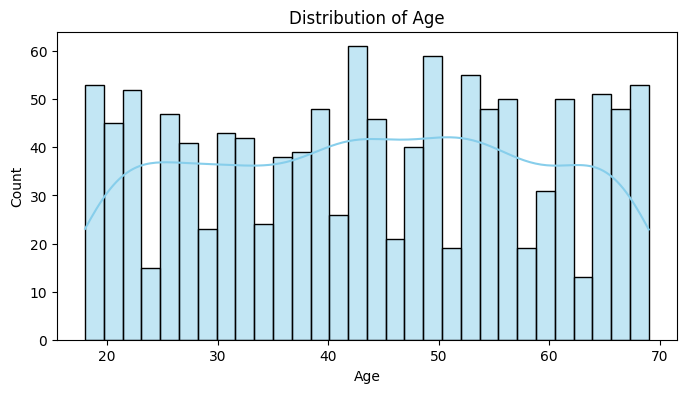

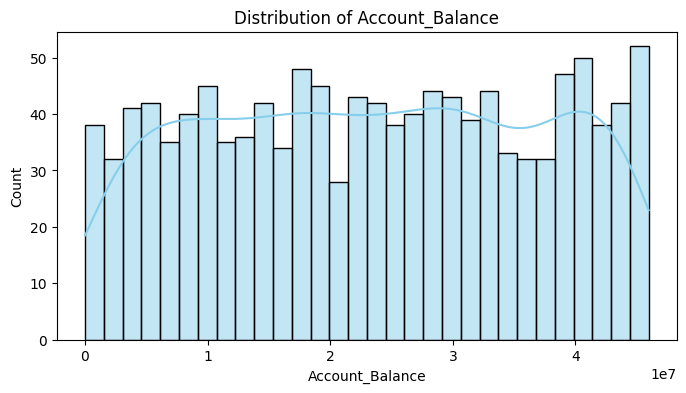

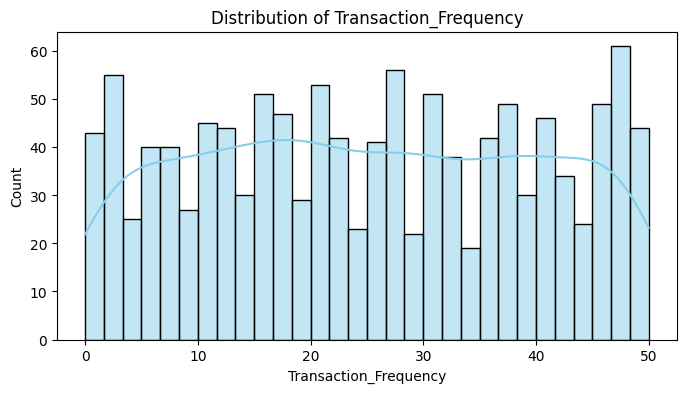

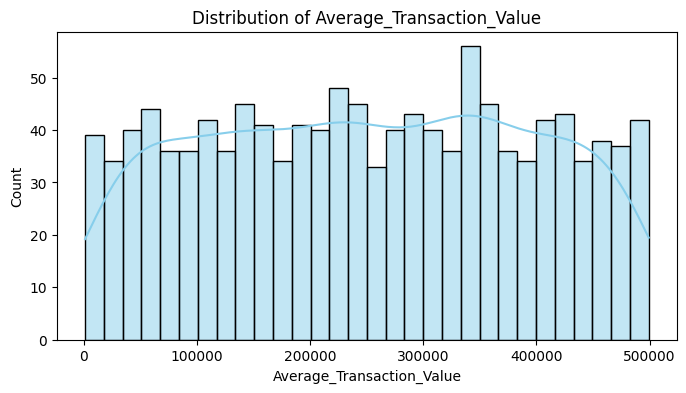

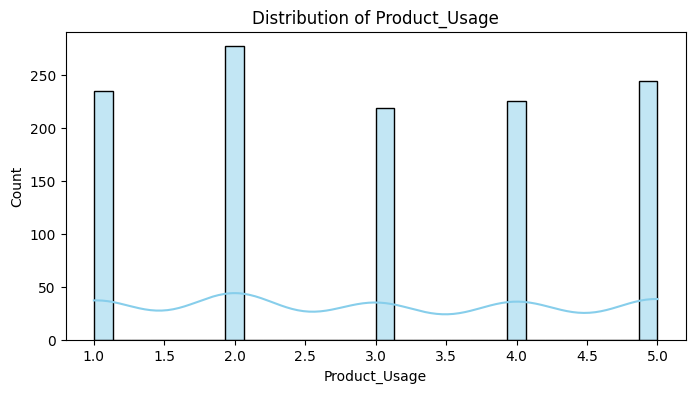

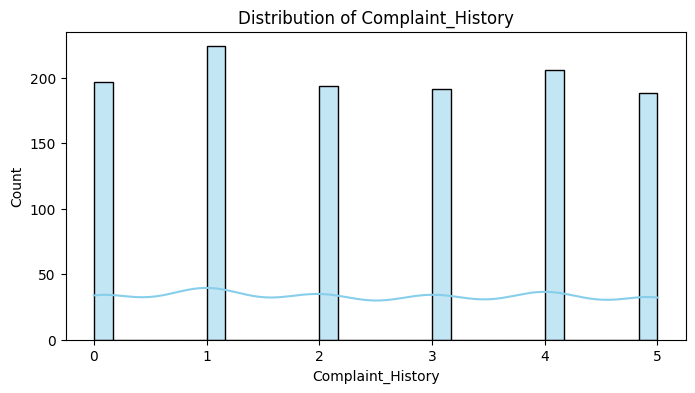

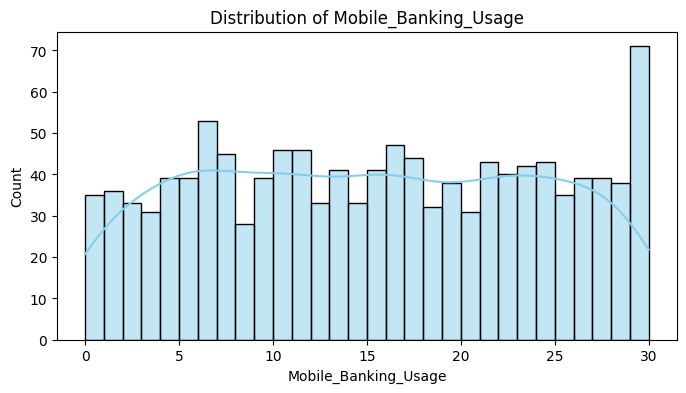

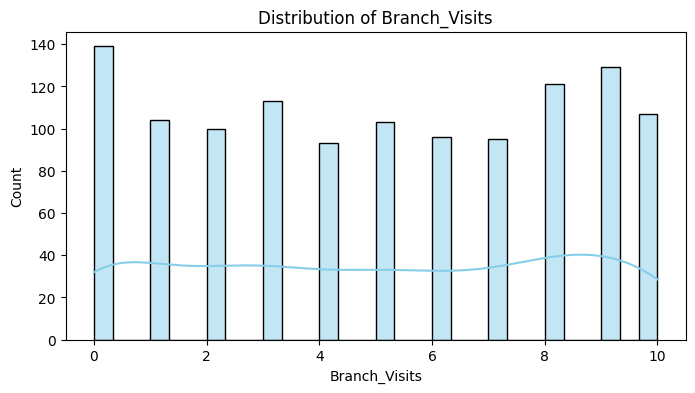

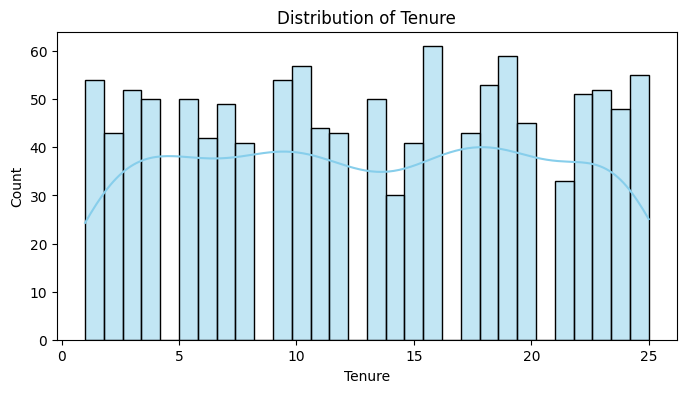

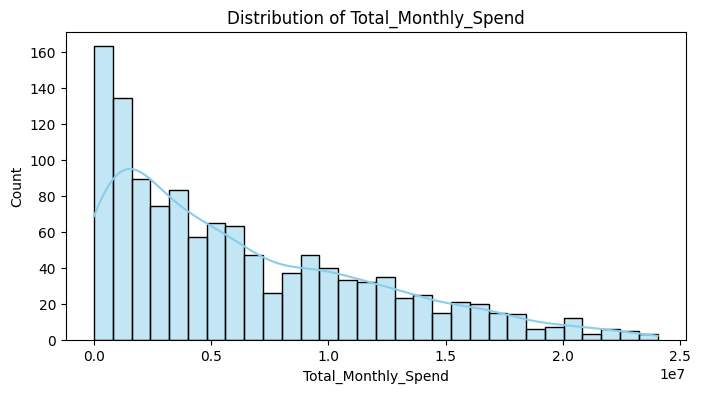

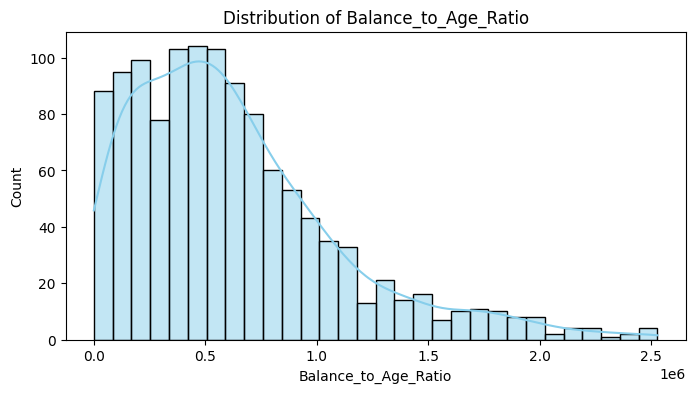

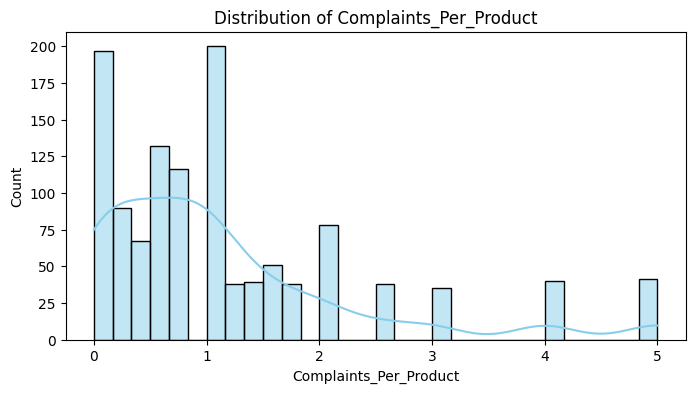

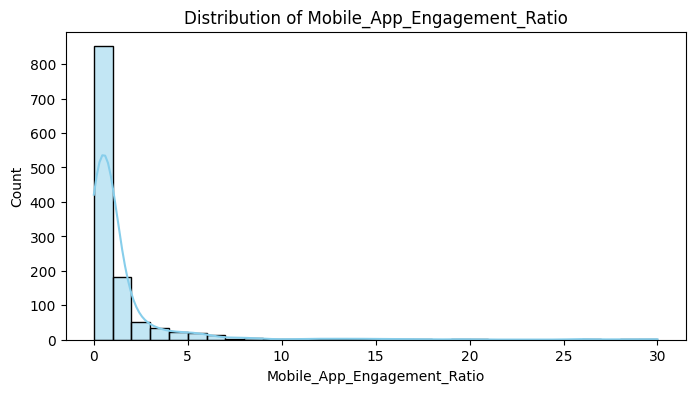

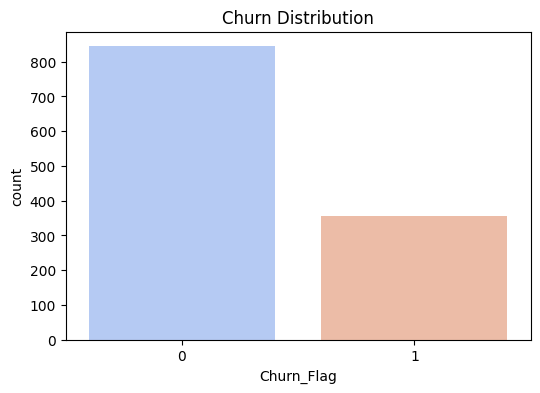

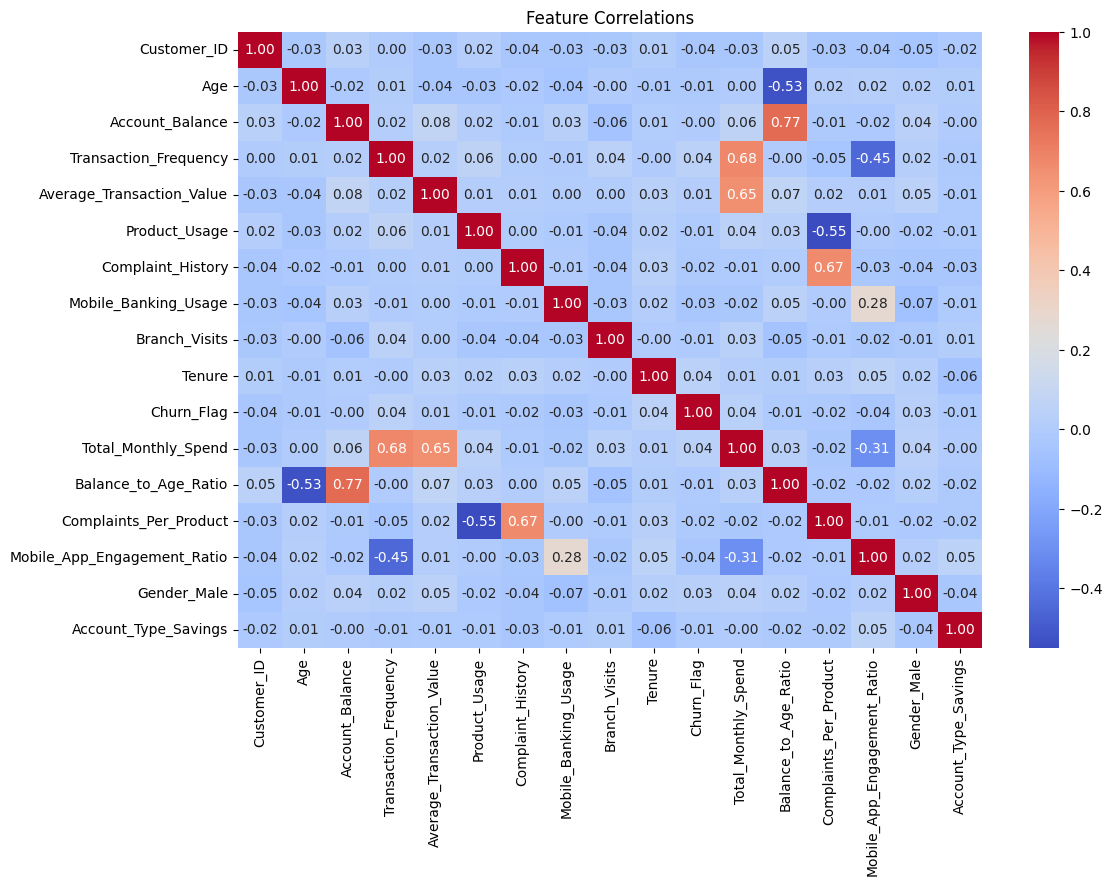

Best Hyperparameters: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300, 'scale_pos_weight': 3, 'subsample': 0.7}
Initial Model Metrics:
Accuracy: 0.3583
Precision: 0.2956
Recall: 0.8451
F1 Score: 0.4380
Confusion Matrix:
 [[ 26 143]
 [ 11  60]]


<Figure size 1200x600 with 0 Axes>

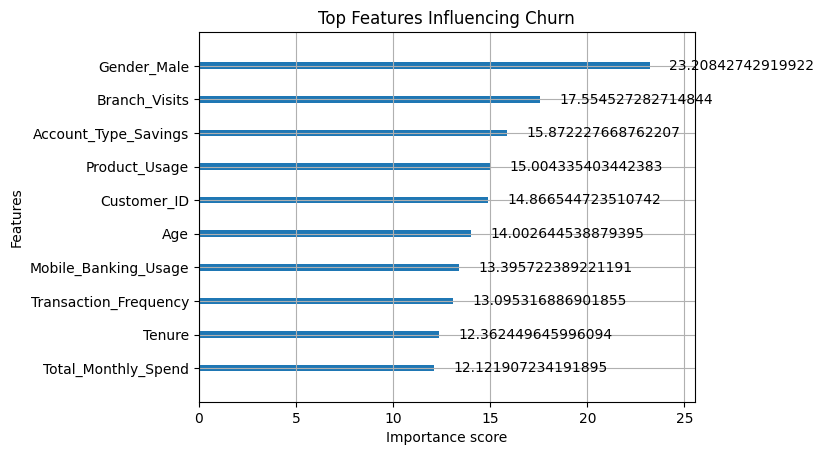

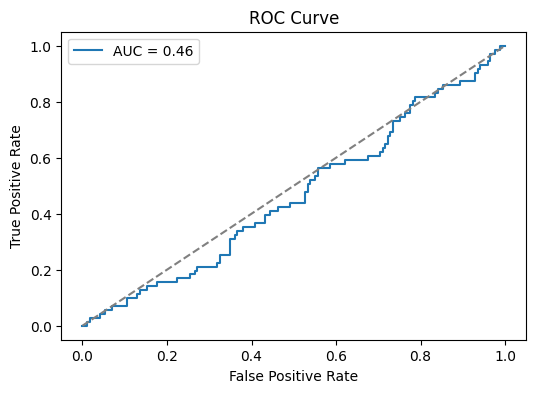

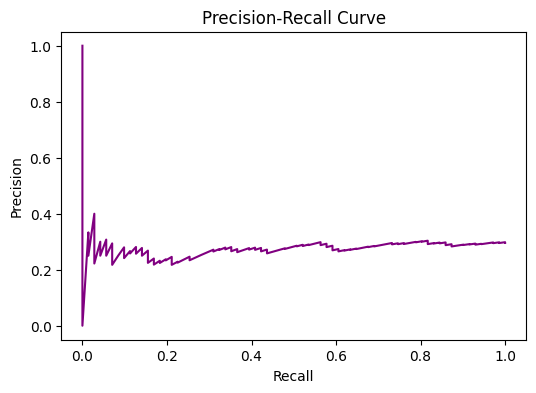

Adjusted Threshold Metrics:
Accuracy: 0.29583333333333334
Precision: 0.29583333333333334
Recall: 1.0
F1 Score: 0.4565916398713826
Confusion Matrix:
 [[  0 169]
 [  0  71]]
Model saved as 'ensemble_churn_model.pkl'. Ready for deployment!


In [ ]:
# ============================================
# Rwandan Bank Churn Prediction - Assignment-Ready Colab Notebook
# Includes EDA, Fine-Tuning, Ensemble, Visualizations, Threshold Adjustment, Deployment
# ============================================

# ---------------------------
# 1️⃣ Data Loading & Preprocessing
# ---------------------------
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Load dataset
data = pd.read_csv('Rwandan_Bank_Churn_Dataset.csv')

# Fill missing numeric values (if any)
num_cols = data.select_dtypes(include=['float64','int64']).columns
data[num_cols] = data[num_cols].fillna(data[num_cols].median())

# Encode categorical variables
data = pd.get_dummies(data, columns=['Gender','Account_Type'], drop_first=True)

# Feature Engineering
data['Total_Monthly_Spend'] = data['Transaction_Frequency'] * data['Average_Transaction_Value']
data['Balance_to_Age_Ratio'] = data['Account_Balance'] / data['Age']
data['Complaints_Per_Product'] = data['Complaint_History'] / data['Product_Usage']
data['Mobile_App_Engagement_Ratio'] = data['Mobile_Banking_Usage'] / data['Transaction_Frequency']

# Replace inf or -inf values with NaN (to avoid scaler errors)
features_to_scale = data.drop('Churn_Flag', axis=1).columns
data[features_to_scale] = data[features_to_scale].replace([np.inf, -np.inf], np.nan)
data[features_to_scale] = data[features_to_scale].fillna(data[features_to_scale].median())

# Scale numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data[features_to_scale])
y = data['Churn_Flag']

# ---------------------------
# 2️⃣ Exploratory Data Analysis (EDA) & Visualizations
# ---------------------------
import matplotlib.pyplot as plt
import seaborn as sns

num_features = ['Age','Account_Balance','Transaction_Frequency','Average_Transaction_Value','Product_Usage',
                'Complaint_History','Mobile_Banking_Usage','Branch_Visits','Tenure','Total_Monthly_Spend',
                'Balance_to_Age_Ratio','Complaints_Per_Product','Mobile_App_Engagement_Ratio']

for col in num_features:
    plt.figure(figsize=(8,4))
    sns.histplot(data[col], kde=True, bins=30, color='skyblue')
    plt.title(f'Distribution of {col}')
    plt.show()

# Churn distribution
plt.figure(figsize=(6,4))
sns.countplot(x='Churn_Flag', data=data, palette='coolwarm', hue='Churn_Flag', legend=False)
plt.title('Churn Distribution')
plt.show()

# Correlation heatmap
plt.figure(figsize=(12,8))
sns.heatmap(data.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Feature Correlations')
plt.show()

# ---------------------------
# 3️⃣ Handle Class Imbalance (SMOTE)
# ---------------------------
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    data.drop('Churn_Flag', axis=1), y, test_size=0.2, random_state=42, stratify=y)

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# ---------------------------
# 4️⃣ Model Architecture & Hyperparameter Fine-Tuning
# ---------------------------
from xgboost import XGBClassifier, plot_importance
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Base XGBoost model (GPU compatible)
xgb_base = XGBClassifier(random_state=42, tree_method='hist', device='cuda', eval_metric='logloss')

# Hyperparameter grid
param_grid = {
    'n_estimators': [300, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'subsample': [0.7, 0.8, 1],
    'colsample_bytree': [0.7, 0.8, 1],
    'scale_pos_weight': [1, 2, 3]
}

grid_search = GridSearchCV(estimator=xgb_base, param_grid=param_grid, scoring='recall', cv=3, n_jobs=-1)
grid_search.fit(X_train_res, y_train_res)

# Best XGBoost model
xgb_model = grid_search.best_estimator_
print("Best Hyperparameters:", grid_search.best_params_)

# Combine with Logistic Regression in an ensemble
log_model = LogisticRegression(max_iter=1000)
ensemble_model = VotingClassifier(estimators=[('xgb', xgb_model), ('log', log_model)], voting='soft')
ensemble_model.fit(X_train_res, y_train_res)

# ---------------------------
# 5️⃣ Model Evaluation
# ---------------------------
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, precision_recall_curve

# Predict
y_pred = ensemble_model.predict(X_test)
y_proba = ensemble_model.predict_proba(X_test)[:,1]

# Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Initial Model Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Feature Importance from XGBoost inside ensemble
plt.figure(figsize=(12,6))
plot_importance(ensemble_model.named_estimators_['xgb'], max_num_features=10, importance_type='gain')
plt.title('Top Features Influencing Churn')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Precision-Recall Curve
precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_proba)
plt.figure(figsize=(6,4))
plt.plot(recall_vals, precision_vals, color='purple')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# ---------------------------
# 6️⃣ Threshold Adjustment to Max Recall
# ---------------------------
threshold = 0.3
y_pred_thresh = (y_proba >= threshold).astype(int)

print("Adjusted Threshold Metrics:")
print("Accuracy:", accuracy_score(y_test, y_pred_thresh))
print("Precision:", precision_score(y_test, y_pred_thresh))
print("Recall:", recall_score(y_test, y_pred_thresh))
print("F1 Score:", f1_score(y_test, y_pred_thresh))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_thresh))

# ---------------------------
# 7️⃣ Save Model for Deployment
# ---------------------------
import joblib
joblib.dump(ensemble_model, 'ensemble_churn_model.pkl')
print("Model saved as 'ensemble_churn_model.pkl'. Ready for deployment!")